This notebook is based on code from
https://towardsdatascience.com/principal-component-regression-clearly-explained-and-implemented-608471530a2f

The performance of PCR against three other regression models is compare using Root Mean Squared Error (RMSE). RMSE is a metric which which portrays the precision of a model. The number represents the distance between true values from the dataset and predicted values generated by the model, and is calculated by: $\sqrt{\frac{1}{N}\sum_i^N (x_i - \bar{x}_i)^2}$ where $x$ is the true value and $\bar{x}$ is the predicted.

The RMSE is the standard deviation of the residuals. The lower the value, the less error is present.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# Data

In [11]:
df = pd.read_csv('./data/winequality-red.csv', sep=';')

In [13]:
target = "quality"
X = df.drop(target, axis=1)
y = df[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization

In [15]:
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Regression Benchmarks 

In [16]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [17]:
lin_reg = LinearRegression().fit(X_train_scaled, y_train)
lr_score_train = -1 * cross_val_score(lin_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lr_score_test = mean_squared_error(y_test, lin_reg.predict(X_test_scaled), squared=False)

In [18]:
lasso_reg = LassoCV().fit(X_train_scaled, y_train)
lasso_score_train = -1 * cross_val_score(lasso_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
lasso_score_test = mean_squared_error(y_test, lasso_reg.predict(X_test_scaled), squared=False)

In [19]:
ridge_reg = RidgeCV().fit(X_train_scaled, y_train)
ridge_score_train = -1 * cross_val_score(ridge_reg, X_train_scaled, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()
ridge_score_test = mean_squared_error(y_test, ridge_reg.predict(X_test_scaled), squared=False)

# PCA

In [20]:
pca = PCA()
X_train_pc = pca.fit_transform(X_train_scaled)
pd.DataFrame(pca.components_.T).loc[:4,:]

,0,1,2,3,4,5,6,7,8,9,10
0,0.486819,-0.109289,-0.151640,-0.211996,-0.116956,0.151683,-0.334642,-0.176844,-0.205265,-0.236659,0.636428
1,-0.230695,0.293355,-0.442608,0.128183,0.204407,0.476617,-0.468471,-0.081351,0.129516,0.369572,-0.001684
2,0.467369,-0.157400,0.220984,-0.097646,-0.055669,0.067697,0.140384,-0.383500,0.348557,0.629722,-0.076931
3,0.152336,0.239182,0.049249,-0.406056,0.722412,0.040310,0.280960,0.324788,0.014840,0.076839,0.195514
4,0.216295,0.149466,-0.021770,0.663833,0.286446,0.234620,0.391538,-0.352225,-0.128421,-0.236930,0.051357


In [22]:
print(pca.explained_variance_ratio_)

[0.2801769  0.17563995 0.13957636 0.11081822 0.09021248 0.05908698
 0.05266627 0.03883888 0.03129468 0.01600997 0.0056793 ]


# Dimension Reduction

In [23]:
lin_reg = LinearRegression()
rmse_list = [] # for dimensions 1 to N
for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i],
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)

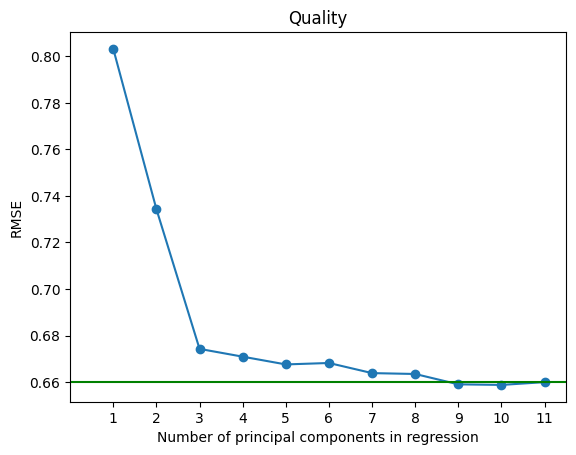

In [24]:
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('RMSE')
plt.title('Quality')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=lr_score_train, color='g', linestyle='-');

# Comparison

In [25]:
best_pc_num = 9

In [26]:
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

In [27]:
pcr_score_train = -1 * cross_val_score(lin_reg_pc, 
                                       X_train_pc[:,:best_pc_num], 
                                       y_train, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()

In [28]:
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)

In [29]:
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

In [30]:
preds = lin_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)

In [37]:
print("Performance (RMSE) on test data:")
print("PCR:", pcr_score_test)
print("Linear Regression:", lr_score_test)
print("Lasso Regression:", lasso_score_test)
print("Ridge Regression:", ridge_score_test)

Performance (RMSE) on test data:
PCR: 0.627365163186139
Linear Regression: 0.6251306211067055
Lasso Regression: 0.6270782498171976
Ridge Regression: 0.6252454963271429


As shown above, PCR produces results competitive to the results of the othe regression models.